---------------


### 1. Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
import os
pd.set_option("display.max_columns", None)
from PIL import Image
import cv2
import datetime
import gc
import glob
import seaborn as sns
import tensorflow as tf
from mlxtend.plotting import plot_confusion_matrix
import keras
from keras.models import Sequential, Model, load_model
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import Adam,SGD
from keras import backend as K
from tqdm.notebook import tqdm
#from keras_vggface.vggface import VGGFace
from tensorflow.python.framework import ops
from time import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,roc_auc_score
from keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dropout, Flatten, Dense, Input,Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.nn import relu, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.xception import Xception

In [2]:
# Setting up the metrics
def plot_performance_metrics(model):
    '''
    A function that generates the Loss and the Accuracy plots
    
    '''
    tr_loss = model.history['loss']
    val_loss = model.history['val_loss']
    tr_accuracy = model.history['accuracy'] # f1 is changes to accuracy if it is used
    val_accuracy = model.history['val_accuracy'] # val_f1 is changes to val_accuracy if accuracy is used
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    plt.subplots_adjust(wspace=0.40)


    ax1.plot(tr_loss)
    ax1.plot(val_loss)
    ax1.grid()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(['Train Loss', 'Test Loss'], loc='upper right')
    ax1.set_title('Plot of Train and Test Loss against Epochs')
    

    ax2.plot(tr_accuracy)
    ax2.plot(val_accuracy)
    ax2.grid()
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy Score')
    ax2.legend(['Train Accuracy-Score', 'Test Accuracy-Score'], loc='upper right')
    ax2.set_title('Plot of Train and Test Accuracy-Score against Epochs')
    plt.show()

### 2. Sample images from all the classes in train dataset

In [3]:
def load_dataset(directory):
    '''
    A function that loads the dataset
    '''
    
    image_paths = []
    labels = []
    directory_ = os.listdir(directory)
    directory_.remove('.DS_Store')
    for folder in directory_:
        for filename in os.listdir(directory+folder):
            image_path = os.path.join(directory, folder, filename)
            image_paths.append(image_path)
            labels.append(folder)
            
        print(folder, "Completed")
        
    return image_paths, labels

### 3. Exploratory Data Analysis

In [4]:
train_directory = "train/"
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(train_directory)
train = train.sample(frac=1).reset_index(drop=True)
train.head()

happy Completed
sad Completed
fear Completed
surprise Completed
neutral Completed
angry Completed
disgust Completed


,image,label
0,train/sad/train_sad_135.jpg,sad
1,train/happy/train_happy_5259.jpg,happy
2,train/happy/train_happy_5208.jpg,happy
3,train/fear/train_fear_1089.jpg,fear
4,train/neutral/train_neutral_4955.jpg,neutral


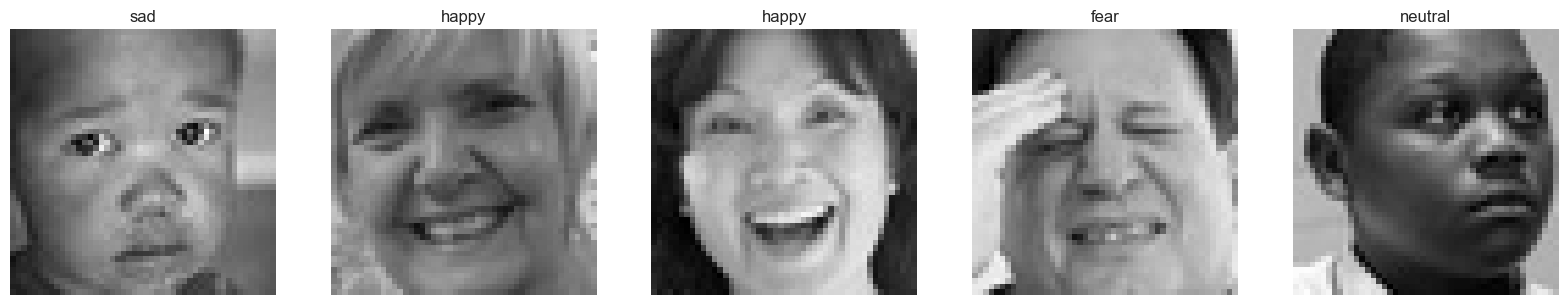

In [5]:
plt.figure(figsize=(20,20))
files = train.iloc[0:5]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

In [6]:
test_directory = "test/"
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(test_directory)
# shuffle the dataset
test = train.sample(frac=1).reset_index(drop=True)
test.head()

happy Completed
sad Completed
fear Completed
surprise Completed
neutral Completed
angry Completed
disgust Completed


,image,label
0,train/neutral/train_neutral_672.jpg,neutral
1,train/happy/train_happy_78.jpg,happy
2,train/neutral/train_neutral_3755.jpg,neutral
3,train/happy/train_happy_2104.jpg,happy
4,train/sad/train_sad_760.jpg,sad


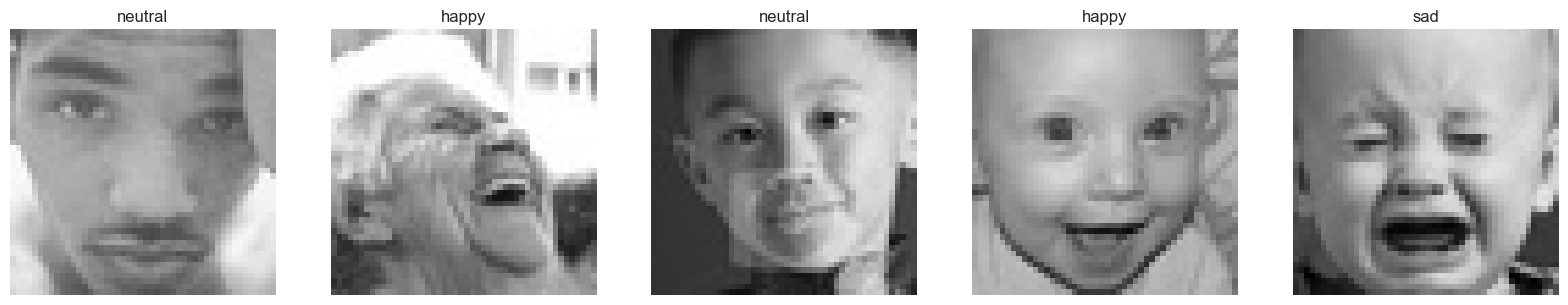

In [7]:
plt.figure(figsize=(20,20))
files = test.iloc[0:5]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

Text(0, 0.5, 'Counts')

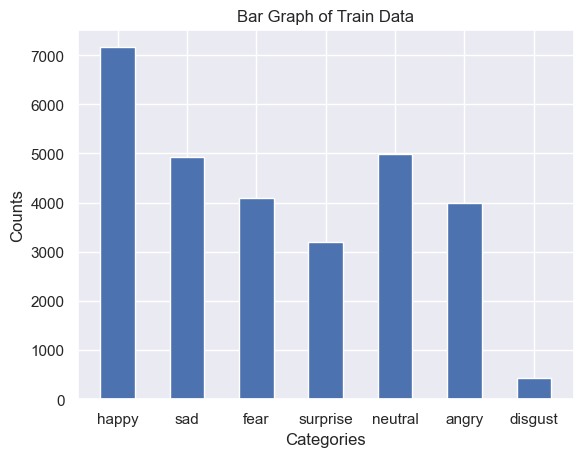

In [8]:
# Plotting the the distribution of target varaiables
train_directory = "train/"
train_dir = os.listdir(train_directory)
train_dir.remove('.DS_Store')

classes_train = []
train_counts = []

for folder in train_dir:
    classes_train.append(folder)

for folder in train_dir:
    class_path = train_directory + folder + "/"
    list_train = []
    count = 0
    for file in os.listdir(class_path):
        count +=1
    
    train_counts.append(count)
    
plt.bar(classes_train, train_counts, width=0.5)
plt.title("Bar Graph of Train Data")
plt.xlabel("Categories")
plt.ylabel("Counts")

Text(0, 0.5, 'Counts')

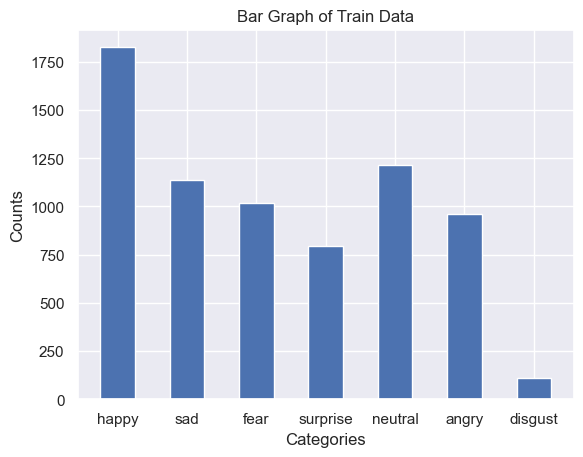

In [9]:
test_directory = "test/"
test_dir = os.listdir(train_directory)
test_dir.remove('.DS_Store')

classes_test = []
test_counts = []

for folder in test_dir:
    classes_test.append(folder)

for folder in test_dir:
    class_path = test_directory + folder + "/"
    list_test = []
    count = 0
    for file in os.listdir(class_path):
        count +=1
    
    test_counts.append(count)
    
plt.bar(classes_test, test_counts, width=0.5)
plt.title("Bar Graph of Train Data")
plt.xlabel("Categories")
plt.ylabel("Counts")

### 4. Assigning data to train and test data

In [10]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [11]:
train_features = extract_features(train['image']) 

  0%|          | 0/28820 [00:00<?, ?it/s]

/Users/adeniyim/miniforge3/envs/tensor_env/lib/python3.8/site-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [12]:
nb_train = train_features.shape[0]
train_features.shape

(28820, 48, 48, 1)

In [13]:
test_features = extract_features(test['image'])

  0%|          | 0/28820 [00:00<?, ?it/s]

In [14]:
nb_test = test_features.shape[0]
test_features.shape

(28820, 48, 48, 1)

In [15]:
x_train = train_features
x_test = test_features

In [16]:
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [17]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [18]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0.], dtype=float32)

### 5. Build a data augmentation for train data to create new data with translation, rescale and flip, and rotation transformations. Rescale the image at 48x48

In [19]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)

In [20]:
train_datagen.fit(x_train)

In [21]:
test_datagen.fit(x_test)

In [22]:
# set up
output_class = 7

# Building CNN Model

### Model 1 : CNN Architecture

In [23]:
classifier = Sequential()
classifier.add(Convolution2D(32, 3, 3, input_shape = (48, 48, 1), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.2))
classifier.add(BatchNormalization())
classifier.add(Flatten())
classifier.add(Dense(output_class, activation='softmax'))


classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [24]:
# Printing out the summary of CNN Architecture.
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 8, 8, 32)          0         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 32)         128       
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 7)                 1

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

earlyStopping = EarlyStopping(monitor='val_loss', mode='min', baseline=None, 
                              restore_best_weights=True, patience = 8, verbose = 1)
checkpoint = ModelCheckpoint("emotions.h5", monitor='accuracy', verbose=1,
                              save_best_only=True, mode='auto', period=1)
reduce = ReduceLROnPlateau(monitor='accuracy', factor=0.2, patience=10, 
                           min_lr=0.0001, verbose = 1)

In [26]:
%load_ext tensorboard
logdir='logs/model_1_'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_Visualization = TensorBoard(log_dir=logdir, histogram_freq=False)

In [27]:
result = classifier.fit(x=x_train, y=y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
  1/226 [..............................] - ETA: 35s - loss: 2.6274 - accuracy: 0.1797

2023-01-09 12:14:09.732771: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


226/226 [==============================] - 2s 7ms/step - loss: 1.9327 - accuracy: 0.2926 - val_loss: 1.5719 - val_accuracy: 0.4031
Epoch 2/50
226/226 [==============================] - 2s 7ms/step - loss: 1.6169 - accuracy: 0.3820 - val_loss: 1.4697 - val_accuracy: 0.4432
Epoch 3/50
226/226 [==============================] - 2s 7ms/step - loss: 1.5523 - accuracy: 0.4068 - val_loss: 1.4624 - val_accuracy: 0.4377
Epoch 4/50
226/226 [==============================] - 2s 7ms/step - loss: 1.5099 - accuracy: 0.4196 - val_loss: 1.4120 - val_accuracy: 0.4658
Epoch 5/50
226/226 [==============================] - 2s 7ms/step - loss: 1.4862 - accuracy: 0.4351 - val_loss: 1.3919 - val_accuracy: 0.4757
Epoch 6/50
226/226 [==============================] - 2s 7ms/step - loss: 1.4707 - accuracy: 0.4400 - val_loss: 1.3706 - val_accuracy: 0.4834
Epoch 7/50
226/226 [==============================] - 2s 7ms/step - loss: 1.4614 - accuracy: 0.4435 - val_loss: 1.3718 - val_accuracy: 0.4836
Epoch 8/50
226/22

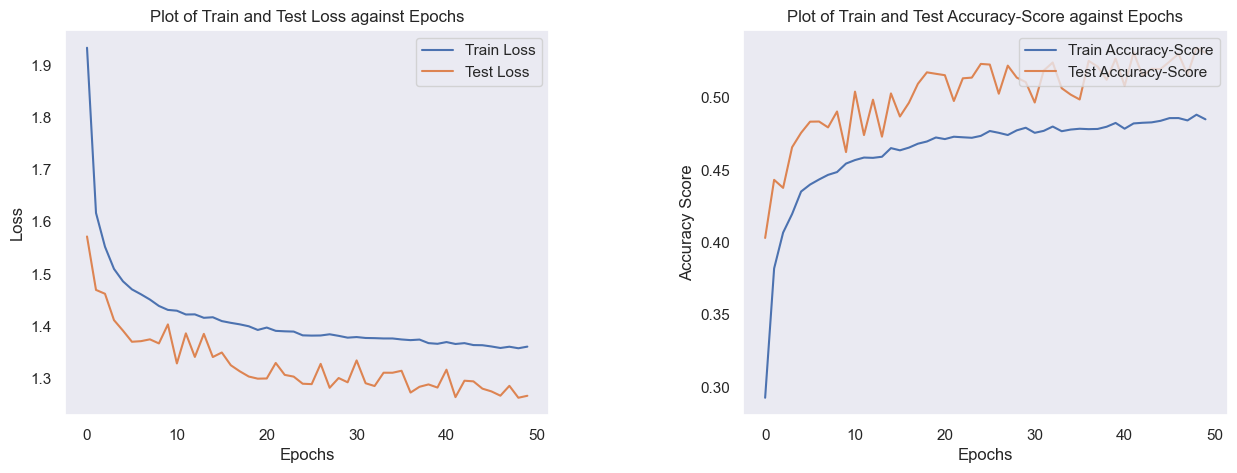

In [28]:
# Loss and Accuracy plots with 50 Epochs
plot_performance_metrics(result)

Original Output: sad
1/1 [==============================] - 0s 36ms/step
Predicted Output: sad


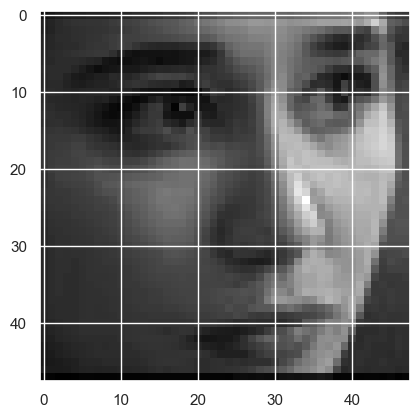

In [29]:
# Testing our model
image_index = np.random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = classifier.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

In [30]:
# Final prediction of test images.
predictions = classifier.predict(x_test)
pred = np.argmax(predictions, axis=1)
y_test_ = np.argmax(y_test, axis=1)

901/901 [==============================] - 1s 714us/step


In [31]:
print(classification_report(y_test_, pred))

              precision    recall  f1-score   support

           0       0.46      0.40      0.43      3992
           1       0.95      0.32      0.48       436
           2       0.53      0.28      0.37      4103
           3       0.57      0.80      0.66      7164
           4       0.47      0.54      0.50      4982
           5       0.45      0.40      0.42      4938
           6       0.72      0.62      0.67      3205

    accuracy                           0.53     28820
   macro avg       0.59      0.48      0.51     28820
weighted avg       0.53      0.53      0.52     28820



In [32]:
## SCORES ARE NOT TOO GOOD

-----------------

### Model 2 : CNN Architecture (Better Custormization)

In [33]:
classifier = Sequential()
classifier.add(Convolution2D(32, 3, 3, input_shape = (48, 48, 1), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.2))
classifier.add(BatchNormalization())
classifier.add(Flatten())
classifier.add(Dense(512, activation = 'relu')) # this is the guy, additional layer commented out will even make it worse
classifier.add(Dense(output_class, activation='softmax'))


classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [34]:
# Summary of CNN Architecture.
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 32)          0         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 32)         128       
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 512)              

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard


earlyStopping = EarlyStopping(monitor='val_loss', mode='min', baseline=None, 
                              restore_best_weights=True, patience = 8, verbose = 1)
checkpoint = ModelCheckpoint("emotions.h5", monitor='accuracy', verbose=1,
                              save_best_only=True, mode='auto', period=1)
reduce = ReduceLROnPlateau(monitor='accuracy', factor=0.2, patience=10, 
                           min_lr=0.0001, verbose = 1)

In [36]:
%load_ext tensorboard
logdir='logs/model_1_'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_Visualization = TensorBoard(log_dir=logdir, histogram_freq=False)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [37]:
result = classifier.fit(x=x_train, y=y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
226/226 [==============================] - 3s 13ms/step - loss: 1.7912 - accuracy: 0.3428 - val_loss: 1.4355 - val_accuracy: 0.4633
Epoch 2/50
226/226 [==============================] - 3s 13ms/step - loss: 1.4360 - accuracy: 0.4546 - val_loss: 1.2157 - val_accuracy: 0.5589
Epoch 3/50
226/226 [==============================] - 3s 13ms/step - loss: 1.2925 - accuracy: 0.5111 - val_loss: 1.0498 - val_accuracy: 0.6411
Epoch 4/50
226/226 [==============================] - 3s 13ms/step - loss: 1.1483 - accuracy: 0.5718 - val_loss: 0.8545 - val_accuracy: 0.7096
Epoch 5/50
226/226 [==============================] - 3s 13ms/step - loss: 1.0077 - accuracy: 0.6315 - val_loss: 0.7064 - val_accuracy: 0.7866
Epoch 6/50
226/226 [==============================] - 3s 13ms/step - loss: 0.8660 - accuracy: 0.6886 - val_loss: 0.5869 - val_accuracy: 0.8401
Epoch 7/50
226/226 [==============================] - 3s 13ms/step - loss: 0.7342 - accuracy: 0.7406 - val_loss: 0.4456 - val_accuracy: 0.8718

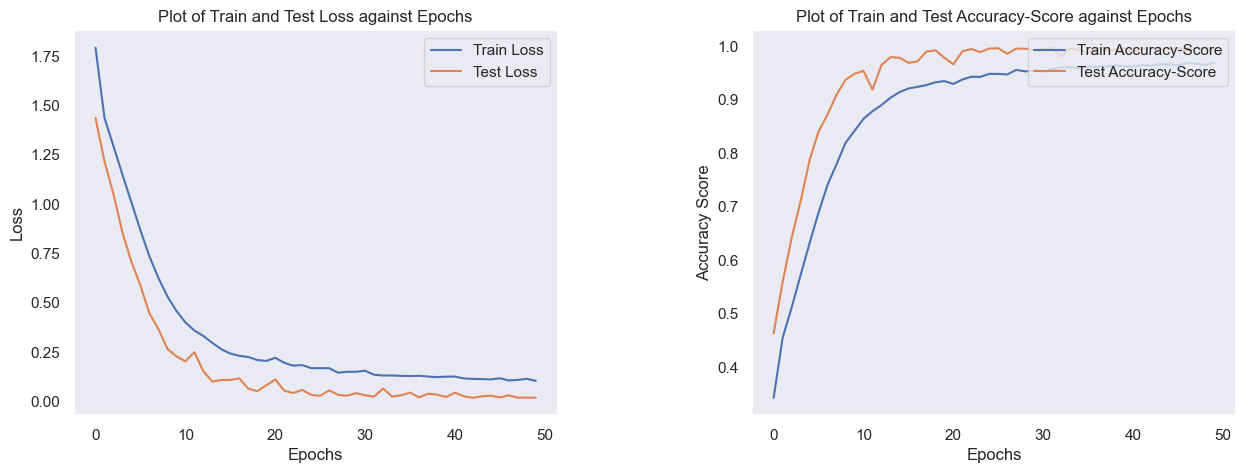

In [38]:
# Loss and Accuracy plots with 50 Epochs
plot_performance_metrics(result)

Original Output: sad
1/1 [==============================] - 0s 25ms/step
Predicted Output: sad


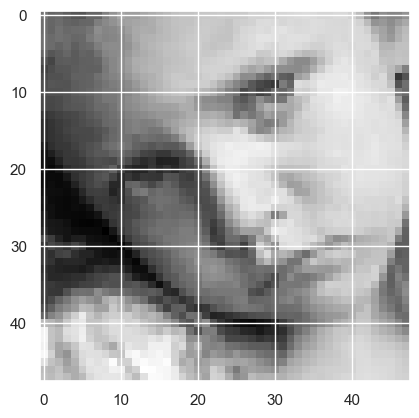

In [39]:
image_index = np.random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = classifier.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

In [40]:
# Final prediction of test images.
predictions = classifier.predict(x_test)
pred = np.argmax(predictions, axis=1)
y_test_ = np.argmax(y_test, axis=1)

901/901 [==============================] - 1s 2ms/step


In [41]:
print(classification_report(y_test_, pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3992
           1       1.00      1.00      1.00       436
           2       0.99      0.99      0.99      4103
           3       1.00      1.00      1.00      7164
           4       1.00      0.99      1.00      4982
           5       0.99      1.00      1.00      4938
           6       0.99      0.99      0.99      3205

    accuracy                           1.00     28820
   macro avg       1.00      1.00      1.00     28820
weighted avg       1.00      1.00      1.00     28820



In [42]:
### VERY GOOD SCORE

-----------------